In [1]:
#First let's import some packages
import xarray as xr
import numpy as np
from xgcm.grid import Grid

In [2]:
unfiltered_vels = xr.open_zarr('/swot/SUM03/spencer/agulhas_vels/unfiltered_vels.zarr')
filtered_vels = xr.open_zarr('/swot/SUM03/spencer/agulhas_vels/filtered_vels.zarr')
eul_filtered_vels = xr.open_zarr('/swot/SUM03/spencer/agulhas_vels/eul_filtered_vels.zarr')

In [3]:
ds = eul_filtered_vels
grid = Grid(ds,coords={'X': {'center': 'i', 'left': 'i_g'},'Y': {'center': 'j', 'left': 'j_g'}})


In [4]:
unf_utransport = unfiltered_vels.u*ds.dyG*ds.hFacW*ds.drF
unf_vtransport = unfiltered_vels.v*ds.dxG*ds.hFacS*ds.drF

In [5]:
div_unf = (grid.diff(unf_utransport, 'X') + grid.diff(unf_vtransport, 'Y')) / ds.raC

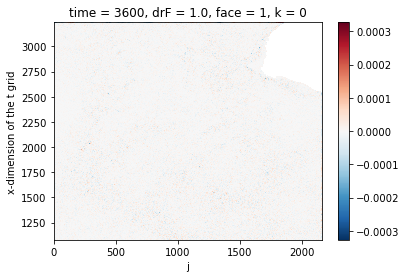

In [8]:
div_unf.isel(time=1).plot()